In [1]:
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os
import scipy.misc as s
import pandas as pd
import random

# data sunsanqq

The labels of each face image is embedded in the file name, formated like [age] _ [gender] _ [race] _ [date&time].jpg

[age] is an integer from 0 to 116, indicating the age

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

https://susanqq.github.io/UTKFace/

In [2]:
files = os.listdir("data/crop_part1/")

In [3]:
image_file = Image.open("data/crop_part1/100_1_0_20170110183726390.jpg.chip.jpg") # open colour image

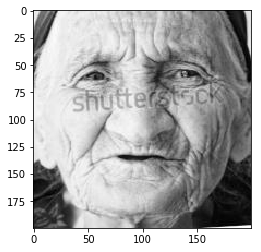

In [4]:
plt.imshow(np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140]), cmap='gray')

In [5]:
random.seed(2)

In [6]:
random.shuffle(files) #randomizing the files to sample from it (this is just to save time)

In [7]:
male_faces = pd.DataFrame([])
female_faces = pd.DataFrame([])
m = 0
fe = 0
for f in files:
    if f.split('_')[1] == "0" and m<200: #male
        m += 1
        image_file = Image.open("data/crop_part1/" + f)
        image_file = image_file.resize((32,32), Image.ANTIALIAS)
        img = np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140])/255 #convert to gray scale
        face = pd.Series(img.flatten(), name=f)
        male_faces = male_faces.append(face)
    if f.split('_')[1] == "1" and fe<200: #female
        fe += 1
        image_file = Image.open("data/crop_part1/" + f)
        image_file = image_file.resize((32,32), Image.ANTIALIAS)
        img = np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140])/255 #convert to gray scale
        face = pd.Series(img.flatten(), name=f)
        female_faces = female_faces.append(face)

In [8]:
male_faces.shape, female_faces.shape

((200, 1024), (200, 1024))

In [9]:
all_faces = pd.concat([male_faces, female_faces], axis=0)
all_faces.shape

(400, 1024)

# Same data as in the paper

Gary B. Huang, Manu Ramesh, Tamara Berg, and Erik Learned-Miller. Labeled faces in the wild: A database for studying face recognition in unconstrained environments. Technical Report 07-49, University of Massachusetts, Amherst, October 2007.

In [32]:
sex = pd.read_csv("data_samsam/data/images/sex.txt").to_dict()["1"] #map from index to sex
imgs = os.listdir("data_samsam/data/images/")[3:-2]

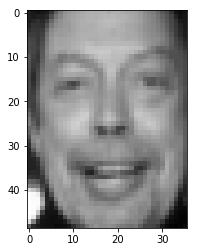

In [33]:
plt.imshow(np.loadtxt("data_samsam/data/images/" + "img0.txt"), cmap='gray')

In [22]:
np.loadtxt("data_samsam/data/images/" + "img1.txt").shape

(49, 36)

In [23]:
imgs[1200][3:-4], sex[int(imgs[0][3:-4])]

('11077', 1)

In [44]:
random.shuffle(imgs)
male_faces = pd.DataFrame([])
female_faces = pd.DataFrame([])
m = 0
fe = 0
for f in imgs:
    if int(f[3:-4]) not in sex:
        continue
    if m < 1000 and sex[int(f[3:-4])] == 1:#male
        male_faces=male_faces.append(pd.Series(np.loadtxt("data_samsam/data/images/" + f).flatten(), name=f[3:-4]))
        m+=1
    if fe < 1000 and sex[int(f[3:-4])] == 0:#female
        female_faces=female_faces.append(pd.Series(np.loadtxt("data_samsam/data/images/" + f).flatten(), name=f[3:-4]))
        fe+=1

In [45]:
female_faces = female_faces/255
male_faces = male_faces/255
all_faces = pd.concat([male_faces, female_faces], axis=0)
all_faces.shape

(2000, 1764)

In [46]:
shape = (49, 36)

# PCA

In [47]:
def pca(X, d):
    u, e, v = np.linalg.svd(X)
    U = np.outer(u[:, 0], v[0, :]) * e[0]
    for i in range(1,d):
        U += np.outer(u[:, i], v[i, :]) * e[i]
    return U

In [57]:
projected = pca(all_faces, 20)

In [49]:
projected.shape

(2000, 1764)

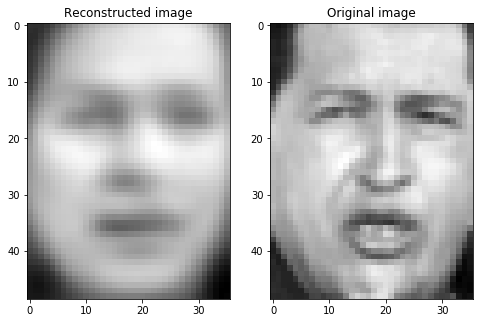

Reconstruction error is :  5.704787908039443


In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(projected[2].reshape(shape), cmap='gray')
axes[0].set_title("Reconstructed image")
axes[1].imshow(np.array(all_faces)[2].reshape(shape), cmap='gray')
axes[1].set_title("Original image")
plt.show()
print("Reconstruction error is : ", np.sum(np.square(np.array(all_faces)[2].reshape(shape) - projected[2].reshape(shape))))

In [58]:
RE_error(all_faces, projected)

11.422432843033716

In [51]:
#Computing reconstruction error 
def RE_error(df1, df2):
    arr1 = np.array(df1)
    arr2 = np.array(df2)
    res = []
    for sample in range(arr2.shape[0]):
        res.append(np.sum(np.square(arr1[sample] - arr2[sample])))
    return np.mean(res)

### Bias between males and females in PCA 

In [54]:
re_male = []
re_female = []
dim = [d for d in range(2,30)]
for d in dim:
    projected = pca(all_faces, d)
    #computing RE for men with dimensionnality reduction d
    re_male.append(RE_error(all_faces[:1000], projected[:1000]))
    #computing RE for women with dimensionnality reduction d
    re_female.append(RE_error(all_faces[1000:], projected[1000:]))

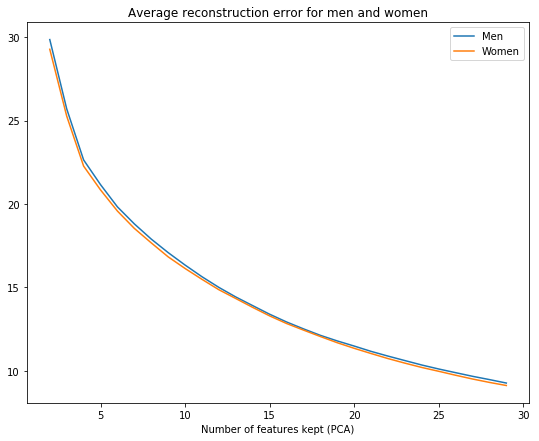

In [55]:
plt.figure(figsize=(9, 7))
plt.plot(dim, re_male, label="Men")
plt.plot(dim, re_female, label="Women")
plt.legend()
plt.title("Average reconstruction error for men and women")
plt.xlabel("Number of features kept (PCA)")
plt.show()

# Fair PCA - Implementation

**First implement the Oracle function**

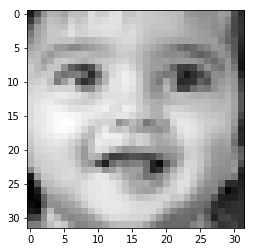

In [67]:
toy = np.array(all_faces)[314].reshape(shape)
plt.imshow(toy, cmap='gray')

In [252]:
u,s,v = np.linalg.svd(toy)
u.shape, s.shape, v.shape

((49, 49), (36,), (36, 36))

In [69]:
d = 20

In [254]:
frob_innerproduct(toy,toy)

859.7542931043412

In [68]:
def frob_innerproduct(a, b):
    return np.trace(a.T @ b)

In [70]:
def oracle(p, alpha, beta, A, B):
    """ Oracle fo Fair PCA - Algorithm 2
        -----------
        Parameters :
        p : tuple of size 2 such that each component are positive and sum to 1.
        alpha : float
        beta : float
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        -----------
        Returns : 
        P, z1, z2 such that : 
            
            P, z1, z2 = argmin p1*z1 + p2*z2
            s.t.
                z1 = alpha - 1/m1 <A'A, P>
                z2 = beta - 1/m1 <B'B, P>
                P is a matrix of size nxn such that 0 <= P <= P and Tr(P) <= d.
    """
    pca = PCA(n_components=d)
    p1, p2, m1, m2 = p[0], p[1], A.shape[0], B.shape[0]
    mat = p1/m1 * A.T @ A + p2/m2 * B.T @ B
    pca.fit(mat)
    V = pca.transform(mat)
    P = V@V.T
    z1 = alpha - (1/m1) * frob_innerproduct(A.T @ A, P)
    z2 = beta - (1/m2) * frob_innerproduct(B.T @ B, P)
    return P, z1, z2

In [71]:
p = [0.5, 0.5]
alpha = 2
beta = 2
A = np.array(male_faces)
B = np.array(female_faces)
A.shape, B.shape

((200, 1024), (200, 1024))

In [72]:
P, z1, z2 = oracle(p, alpha, beta, A, B)

In [73]:
z1, z2

(-19750.297976041747, -34504.10942546777)

In [74]:
P.shape

(1024, 1024)

In [75]:
def MW_PCA(alpha, beta, A, B, eta, T):
    """ Multiplicative weight update for faire PCA - Algorithm 3
        -----------
        Parameters :
        alpha : float
        beta : float
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        eta : float, must be stricly positive
        T : int, must be positive (According to the reference paper, no need for T to be very large : a fews tens)
        -----------
        Returns : 
        P, z such that : 
            
            P, z = argmin z
            s.t.
                z1 >= alpha - 1/m1 <A'A, P>
                z2 >= beta - 1/m2 <B'B, P>
                P is a matrix of size nxn such that 0 <= P <= P and Tr(P) <= d.
    """
    p = [0.5, 0.5] #initialize values for p for the oracle function
    Ps = []
    m1, m2 = A.shape[0], B.shape[0]
    #Looping T times
    for t in range(1, T+1):
        Pt, m1t, m2t = oracle(p, alpha, beta, A, B)
        Ps.append(Pt)
        p_hat1, p_hat2 = p[0] * np.exp(eta*m1), p[1] * np.exp(eta*m2)
        s = p_hat1 + p_hat2
        p = [p_hat1/s, p_hat2/s]
    #return values found
    P = np.mean(Ps, axis=0)
    z = max(alpha - (1/m1) * frob_innerproduct(A.T @ A, P), beta - (1/m2) * frob_innerproduct(B.T @ B, P))
    return P, z

**All steps of algorithm 1 (Fair PCA) are done except step 4 : solving the following linear program** 

We do it now : 

Program :


$\min_{\lambda \in \mathbb{R}^{n}, z \in \mathbb{R}} \; z $

s.t. 

$0 \leq \lambda_i \leq 1$ 


$\sum_{i} \lambda_i \leq d$

$-z - \sum_{i} \lambda_i \cdot <B^{T}B, u_j, u_j^{T}> \; \leq  - \frac{|| \hat{B} ||_F^2}{m2}$


$-z - \sum_{i} \lambda_i \cdot <A^{T}A, u_j, u_j^{T}> \; \leq  - \frac{|| \hat{A} ||_F^2}{m1}$


To solve this linear program we first write it in its canonical form : 



**mettre les formules** 



In [77]:
from cvxopt import matrix, solvers

In [78]:
def rank_approx(M, d):
    """ Low rank approximation of matrices using SVD decomposition
        -----------
        Parameters :
        M : array 
        d : lower dimension wanted
        -----------
        Returns : 
        L, optimal rank d approximation of M.
    """
    M_U, M_eig, M_V = np.linalg.svd(M)
    L = np.outer(M_U[:, 0], M_V[0, :]) * M_eig[0]
    for j in range(1,d):
        L += np.outer(M_U[:, j], M_V[j, :]) * M_eig[j]
    return L

In [137]:
def fair_PCA(A, B, d):
    """ Fair PCA - Algorithm 1
        -----------
        Parameters :
        A : array of shape (m1, n)
        B : array of shape (m2, n)
        d : lower dimension wanted
        -----------
        Returns : 
        U of shape (m, n) st m = m1 + m2 and rank(U) <= d+1
    """
    #step 1 
    m1, m2 = A.shape[1], B.shape[1]
    A_hat = rank_approx(A, d)
    B_hat = rank_approx(B, d)
    print("Step 1 done")
    print("-----------")
    #step 2 
    alpha, beta, eta, T = frob_innerproduct(A_hat, A_hat)/m1, frob_innerproduct(B_hat, B_hat)/m2, 1, 10
    P, z = MW_PCA(alpha, beta, A, B, eta, T)
    print("Step 2 done")
    print("-----------")
    #step 3 
    P_U, P_eig, P_V = np.linalg.svd(P)
    print("Step 3 done")
    print("-----------")
    #step 4 
    #Here we will solve a LP, we first constuct matrices in order to write the LP problem 
    #in a canonical form as explained earlier (so we can use a library to solve it).
    n = A.shape[1]
    #construct a matrix of constraint : 
    A_lp_const = np.pad(np.eye(n), ((1,2), (0,1)), mode='constant', constant_values=((1,0), (0,0)))
    A_lp_const[n+1, n] = -1
    A_lp_const[n+2, n] = -1
    ata = A.T @ A
    btb = B.T @ B
    for j in range(n):
        uut = np.outer(P_U[:, j], P_V[j, :])
        fAj = -frob_innerproduct(ata, uut)/m1
        fBj = -frob_innerproduct(btb, uut)/m2
        A_lp_const[n+1, j] = fAj
        A_lp_const[n+2, j] = fBj
    A_lp_const = np.concatenate((A_lp_const, np.pad(-np.eye(n), ((0,0), (0,1)), mode='constant', constant_values=((0,0), (0,0)))))
    #now construct vector of values (i.e. b ) and coefficients (i.e. c)
    b = np.ones(n+3)
    b[0] = d 
    b[-1] = -frob_innerproduct(B_hat, B_hat)/m2
    b[-2] = -frob_innerproduct(A_hat, A_hat)/m1
    b = np.concatenate((b, np.zeros(n)))
    c = np.zeros(n+1)
    c[-1] = 1
    print("Starting LP solve...")
    #A,b,c must in the "matrix" library format
    coefs = solvers.lp(matrix(list(c)), matrix(A_lp_const), matrix(list(b)),show_progress=False)
    z_opt = np.array(coefs['x'])[-1]
    lambda_bar = np.array(coefs['x'])[:-1]
    print("Step 4 done")
    print("-----------")
    #Step 5 : construct lambda* and P*
    lambda_bar = 1 - np.sqrt(np.maximum(1-lambda_bar,0))
    P_star = np.outer(P_U[:, 0], P_V[0, :]) * lambda_bar[0]
    #faire le warning
    for j in range(1, len(lambda_bar)):
        if lambda_bar[j] > 0.07:
            P_star += np.outer(P_U[:, j], P_V[j, :]) * lambda_bar[j]
    print("Step 5 done")
    print("-----------")
    #Finally construct U (pca matrix)
    U = np.concatenate((A, B)) @ P_star
    return U

In [136]:
U = fair_PCA(A, B, 20)

Step 1 done
-----------
Step 2 done
-----------
Step 3 done
-----------
Starting LP solve...
     pcost       dcost       gap    pres   dres   k/t
 0:  6.5272e+01 -1.6242e+03  1e+04  1e+00  6e+01  1e+00
 1:  6.2260e+01 -5.9733e+02  2e+03  4e-01  2e+01  3e+00
 2:  6.1935e+01 -3.2465e+01  2e+02  6e-02  3e+00  1e+00
 3:  6.1509e+01  2.6669e+01  6e+01  2e-02  1e+00  5e-01
 4:  6.1201e+01  3.7805e+01  4e+01  1e-02  8e-01  2e-01
 5:  6.0983e+01  4.6253e+01  2e+01  9e-03  5e-01  1e-01
 6:  6.0986e+01  4.6437e+01  2e+01  9e-03  5e-01  1e-01
 7:  6.0209e+01  4.5819e+01  2e+01  9e-03  5e-01  1e-01
 8:  5.9895e+01  5.0774e+01  1e+01  6e-03  3e-01  6e-02
 9:  5.9596e+01  5.2172e+01  1e+01  5e-03  3e-01  5e-02
10:  5.9379e+01  5.3189e+01  9e+00  4e-03  2e-01  3e-02
11:  5.9237e+01  5.5005e+01  6e+00  3e-03  1e-01  2e-02
12:  5.9077e+01  5.5764e+01  5e+00  2e-03  1e-01  1e-02
13:  5.8994e+01  5.6280e+01  4e+00  2e-03  1e-01  8e-03
14:  5.8731e+01  5.7232e+01  2e+00  9e-04  5e-02  4e-03
15:  5.8572e+

In [138]:
U.shape

(400, 1024)

In [139]:
np.linalg.matrix_rank(U) #the matrix we got is indeed of rank d = 20 (or d+1)

20

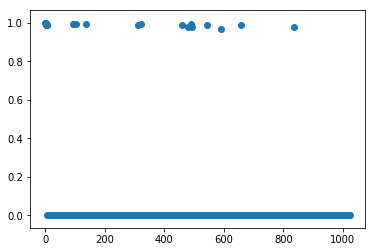

In [126]:
plt.scatter([x for x in range(len(lambda_bar))],lambda_bar)

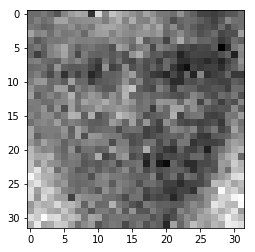

In [141]:
plt.imshow(U[0, :].reshape(shape), cmap='gray')

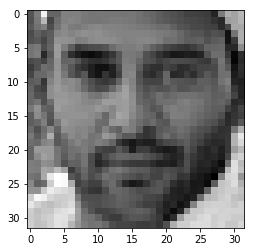

In [142]:
plt.imshow(A[0, :].reshape(shape), cmap='gray')

In [144]:
RE_error(all_faces[:200], U[:200]), RE_error(all_faces[200:], U[200:])

(17.08131486867974, 16.45485785602242)

On peut résoudre le LP avec scipy... c'est pareil

In [66]:
from scipy.optimize import linprog

In [116]:
Alp = A_lp_const.copy()
Alp = np.concatenate((Alp[0, :, None], Alp[1025, :, None], Alp[1026, :, None]), axis=1).T

In [124]:
blp = b.copy()
blp = np.array([blp[0],
blp[1025],
blp[1026]])

array([ 20.        , -65.06107156, -62.52720432])

In [125]:
bounds = []
for k in range(1024):
    bounds.append((0,1))
bounds.append((-np.inf, np.inf))

In [126]:
coefs = linprog(c, A_ub=Alp, b_ub=blp, A_eq=None, b_eq=None, bounds=bounds)

In [127]:
coefs

     con: array([], dtype=float64)
     fun: -4318.618428839305
 message: 'Optimization terminated successfully.'
     nit: 14
   slack: array([-3.81472496e-05,  3.00161703e+02, -2.23724020e-04])
  status: 0
 success: True
       x: array([ 1.04070850e-09,  2.16428153e-09,  2.95464957e-09, ...,
        1.25671377e-08,  1.99935945e-08, -4.31861843e+03])